# Clustering

With `Classification` we want to find a hyperplane that __best separates__ data into similar categories.  
Classification requires __labeled__ data.

With `Clustering` we want to group __unlabeled__ data into __similar__ sets of examples.  
Before you can classify or group similar examples, you need to define __similarity__.

<br>

### Motivation

Assume a set of unlabeled data. You may want to find similarities (within the features).

Our goal is to identify the intrinsic properties of data points that make them belong to the same group - `clusters`. 

In order to find these `clusters`, we use some kind of __similarity measures__ such as __Euclidean distance__. These similarity measure can estimate the tightness of a cluster.  

There is no universal similarity metric that works for all the cases.

It depends on the problem at hand. For example, we might be interested in finding the representative data point for each group or we might be interested in finding the outliers in our data. Depending on the situation, we will end up choosing the appropriate metric.

# k-Means Cluster

A simple but effective clustering algorithm is `k-Means`.

`k-means` follows these steps:

> &nbsp;
> 1. define $ k  \gt 1 $ to group data into $ k $ clusters ($ k $ ... hyperparameter)<br>  
> 2. define $ k $ _cluster centroids_ $ c_i $ (either manually or algorithmically) ... $ max \left( distance \left( k_i - k_j \right) \right) $  
_repeat until equilibrium is reached:_  
> 3. &nbsp;&nbsp;&nbsp;&nbsp;calculate minimum distance of data points to clusters and assign each point a _centroid_ based on the distance $ c_x = min_{i=1..k} \left( x_j - c_i \right) $
> 4. &nbsp;&nbsp;&nbsp;&nbsp;calculate the mean of all data points in a cluster and assign this mean as the new centroid  
> <br><br>

These $ k $ _centroids_ are used for inference (prediction).
<br><br>

<span style="font-size: 70%">k-Means convergence over the iterations. If the centroids don't change beyond a threshold (<b>iterations 12-14</b>), the algorithm has converged and stops.<br>
Source: <a href="https://en.wikipedia.org/wiki/K-means_clustering">Wikipedia</a></span>
<br><br>

In [18]:
# the obligatory imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns


from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans

from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import silhouette_score

### Load and prepare data

In [19]:
df = pd.read_csv('data/secondary_data.csv', sep=';')

# Create a boolean mask for categorical columns
categorical_feature_mask = df.dtypes == object

# Get list of categorical column names
categorical_cols = df.columns[categorical_feature_mask].tolist()

# Get list of non-categorical column names
numeric_cols = df.columns[~categorical_feature_mask].tolist()

if 'class' in categorical_cols:
    categorical_cols.remove('class')

categorical_cols 

['cap-shape',
 'cap-surface',
 'cap-color',
 'does-bruise-or-bleed',
 'gill-attachment',
 'gill-spacing',
 'gill-color',
 'stem-root',
 'stem-surface',
 'stem-color',
 'veil-type',
 'veil-color',
 'has-ring',
 'ring-type',
 'spore-print-color',
 'habitat',
 'season']

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 61069 non-null  object 
 1   cap-diameter          61069 non-null  float64
 2   cap-shape             61069 non-null  object 
 3   cap-surface           46949 non-null  object 
 4   cap-color             61069 non-null  object 
 5   does-bruise-or-bleed  61069 non-null  object 
 6   gill-attachment       51185 non-null  object 
 7   gill-spacing          36006 non-null  object 
 8   gill-color            61069 non-null  object 
 9   stem-height           61069 non-null  float64
 10  stem-width            61069 non-null  float64
 11  stem-root             9531 non-null   object 
 12  stem-surface          22945 non-null  object 
 13  stem-color            61069 non-null  object 
 14  veil-type             3177 non-null   object 
 15  veil-color         

In [21]:
# remove cols with less entries
drop_columns = ['stem-root', 'stem-surface', 'veil-type', 'veil-color', 'spore-print-color']

In [22]:
# convert categorical features to numerical
target = df['class'].apply(lambda x: 1 if x=='e' else 0)

# nan = unknown = -1
df.fillna(-1, inplace=True)

# none=f will be encoded as 0
def feature_label_encoder(x, cat_array):
    if x == -1:
        return x
    elif x in cat_array:
        return cat_array.index(x) + 1
    else:
        return 0

# 2. cap-shape (n): bell=b, conical=c, convex=x, flat=f, sunken=s, spherical=p, others=o
cap_shape_array = ['b', 'c', 'x', 'f', 's', 'p', 'o']
df['cap-shape'] = df['cap-shape'].apply(lambda x: feature_label_encoder(x, cap_shape_array))

# 3. cap-surface (n): fibrous=i, grooves=g, scaly=y, smooth=s, shiny=h, leathery=l, silky=k, sticky=t, wrinkled=w, fleshy=e
cap_surface_array = ['i', 'g', 'y', 's', 'h', 'l', 'k', 't', 'w', 'e']
df['cap-surface'] = df['cap-surface'].apply(lambda x: feature_label_encoder(x, cap_surface_array))

# 4. cap-color (n):  brown=n, buff=b, gray=g, green=r, pink=p, purple=u, red=e, white=w, yellow=y, blue=l, orange=o, black=k
cap_colors = ['n', 'b', 'g', 'r', 'p', 'u', 'e', 'w', 'y', 'l', 'o', 'k']
df['cap-color'] = df['cap-color'].apply(lambda x: feature_label_encoder(x, cap_colors))

# 5. does-bruise-or-bleed (n):	bruises-or-bleeding=t, no=f
df['does-bruise-or-bleed'] = df['does-bruise-or-bleed'].apply(lambda x: 1 if x=='t' else 0)

# 6. gill-attachment (n): adnate=a, adnexed=x, decurrent=d, free=e, sinuate=s, pores=p, none=f, unknown=?
gill_attachment_array = ['a', 'x', 'd', 'e', 's', 'p']
df['gill-attachment'] = df['gill-attachment'].apply(lambda x: feature_label_encoder(x, gill_attachment_array))

# 7. gill-spacing (n): close=c, distant=d, none=f
gill_spacing_array = ['c', 'd']
df['gill-spacing'] = df['gill-spacing'].apply(lambda x: feature_label_encoder(x, gill_spacing_array))

# 8. gill-color (n): see cap-color + none=f
df['gill-color'] = df['gill-color'].apply(lambda x: feature_label_encoder(x, cap_colors))

# 11. stem-root (n):  bulbous=b, swollen=s, club=c, cup=u, equal=e, rhizomorphs=z, rooted=r
stem_root_array = ['b', 's', 'c', 'u', 'e', 'z', 'r']
df['stem-root'] = df['stem-root'].apply(lambda x: feature_label_encoder(x, stem_root_array))

# 12. stem-surface (n): see cap-surface + none=f
df['stem-surface'] = df['stem-surface'].apply(lambda x: feature_label_encoder(x, cap_surface_array))

# 13. stem-color (n): see cap-color + none=f
df['stem-color'] = df['stem-color'].apply(lambda x: feature_label_encoder(x, cap_colors))

# 14. veil-type (n): partial=p, universal=u
veilt_type_array = ['p', 'u']
df['veil-type'] = df['veil-type'].apply(lambda x: feature_label_encoder(x, cap_colors))

# 15. veil-color (n): see cap-color + none=f
df['veil-color'] = df['veil-color'].apply(lambda x: feature_label_encoder(x, cap_colors))

# 16. has-ring (n): ring=t, none=f
df['has-ring'] = df['has-ring'].apply(lambda x: 1 if x=='t' else 0)

# 17. ring-type (n): cobwebby=c, evanescent=e, flaring=r, grooved=g, large=l, pendant=p, sheathing=s, zone=z, scaly=y, movable=m, none=f, unknown=?
ring_type_array = ['c', 'e', 'r', 'g', 'l', 'p', 's', 'z', 'y', 'm']
df['ring-type'] = df['ring-type'].apply(lambda x: feature_label_encoder(x, ring_type_array))

# 18. spore-print-color (n): see cap color
df['spore-print-color'] = df['spore-print-color'].apply(lambda x: feature_label_encoder(x, cap_colors))

# 19. habitat (n): grasses=g, leaves=l, meadows=m, paths=p, heaths=h, urban=u, waste=w, woods=d
habitat_array = ['g', 'l', 'm', 'p', 'h', 'u', 'w', 'd']
df['habitat'] = df['habitat'].apply(lambda x: feature_label_encoder(x, habitat_array))

#  20. season (n): spring=s, summer=u, autumn=a, winter=w
season_array = ['s', 'u', 'a', 'w']
df['season'] = df['season'].apply(lambda x: feature_label_encoder(x, season_array))

In [6]:
df.describe

<bound method NDFrame.describe of       class  cap-diameter  cap-shape  cap-surface  cap-color  \
0         p         15.26          3            2         11   
1         p         16.60          3            2         11   
2         p         14.07          3            2         11   
3         p         14.17          4            5          7   
4         p         14.64          3            5         11   
...     ...           ...        ...          ...        ...   
61064     p          1.18          5            4          9   
61065     p          1.27          4            4          9   
61066     p          1.27          5            4          9   
61067     p          1.24          4            4          9   
61068     p          1.17          5            4          9   

       does-bruise-or-bleed  gill-attachment  gill-spacing  gill-color  \
0                         0                4            -1           8   
1                         0                4     

In [24]:
# Load data
X = df.drop(columns=drop_columns).drop(columns=['class'])

y = target

# prepare data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [8]:
# define k as hyperparameter, take a wild guess
clusters = 2

# model generation
kMeans = KMeans(n_clusters=clusters, n_init="auto")
kMeans.fit(X_train)
train_labels = kMeans.labels_

X_train

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season
16680,7.87,4,5,11,0,5,-1,1,9.49,12.09,1,0,0,8,3
50692,2.76,3,0,1,0,6,-1,7,4.19,8.59,1,0,0,8,3
40942,3.00,3,8,1,0,5,1,5,4.87,8.15,8,1,8,8,3
659,6.14,3,2,1,0,4,-1,8,7.20,13.51,8,1,6,8,3
35521,10.55,3,3,9,0,1,1,1,12.10,14.13,9,1,-1,8,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50057,13.81,3,7,1,1,6,-1,9,10.06,31.63,9,0,0,8,3
32511,2.69,3,0,8,0,3,2,5,3.76,2.41,8,0,0,1,3
5192,11.70,4,-1,3,0,5,1,6,7.36,20.73,2,0,0,2,3
12172,2.83,5,9,6,0,1,1,6,5.76,5.59,6,0,0,8,3


In [25]:
# evaluate model
y_pred = kMeans.predict(X_test)

X_test

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season
60661,6.02,7,-1,1,0,0,0,0,5.00,19.29,1,0,0,8,1
23699,5.10,3,-1,2,0,2,-1,8,6.32,8.27,8,0,0,8,3
60152,8.75,7,-1,7,0,0,0,0,3.15,24.29,1,0,0,8,1
57970,3.34,7,6,3,0,0,0,0,0.00,0.00,0,0,0,8,3
47739,4.85,1,8,1,0,-1,-1,1,10.70,6.56,8,1,-1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32335,4.17,1,8,1,0,2,1,5,6.80,4.78,1,0,0,8,3
43672,10.33,6,3,1,1,4,-1,5,9.01,16.85,8,1,5,8,3
55142,4.18,7,6,1,0,0,0,0,7.47,53.14,1,0,0,2,4
2384,7.00,1,8,8,0,4,1,8,12.15,12.36,8,1,2,8,2


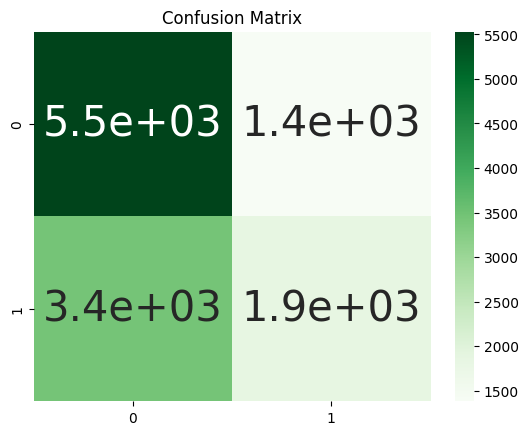

In [26]:
from sklearn.metrics import confusion_matrix, accuracy_score

# generate a confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm

# visualize the confusion matrix
ax = plt.axes()
sns.heatmap(cm, annot=True, annot_kws={"size": 30}, cmap="Greens", ax=ax)
ax.set_title('Confusion Matrix')
plt.show()

In [27]:
accuracy = accuracy_score(y_test, y_pred)*100
print(f'Accuracy of our model is equal {str(round(accuracy, 2))} %.')

Accuracy of our model is equal 60.5 %.


# Principal Component Analysis (PCA)

`PCA` extracts the most important information. This in turn leads to compression since the less important information are discarded.   
With fewer data points to consider, it becomes simpler to describe and analyze the dataset.

### Critical evaluation

- Since `PCA` does not require labeled data, it is an unsupervised learning algorithm

- `PCA` is lossy. Information is lost when we discard insignificant components. However, this loss is minimized.

- `PCA` enables easier data visualization by reducing the number of dimensions

- `PCA` works only if the observed variables are linearly correlated. If there's no correlation, PCA will fail to capture adequate variance with fewer components

- Scaling of variables can yield different results - document scaling

- Since each principal components is a linear combination of the original features, visualizations are not easy to interpret or relate to original features.


In [28]:
from sklearn.decomposition import PCA

# train model
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)

pca_df = pd.DataFrame(data=principalComponents, columns=["PC1", "PC2"])
pca_df['class'] = target

# how much variance does the PC expain
explained = np.around(pca.explained_variance_ratio_*100, 2)

pca_df

,PC1,PC2,class
0,9.474177,8.404058,0
1,11.132592,8.653580,0
2,9.738295,8.136229,0
3,8.071006,5.359010,0
4,9.382743,7.865779,0
...,...,...,...
61064,-8.187388,0.668983,0
61065,-9.015091,0.740697,0
61066,-8.030265,0.662407,0
61067,-8.962340,0.757514,0


In [33]:
# evaluate model
y_pred = kMeans.predict(X_test)

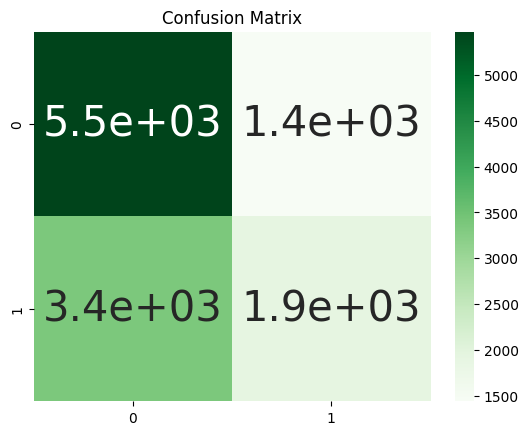

In [35]:
# generate a confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm

# visualize the confusion matrix
ax = plt.axes()
sns.heatmap(cm, annot=True, annot_kws={"size": 30}, cmap="Greens", ax=ax)
ax.set_title('Confusion Matrix')
plt.show()

In [36]:
accuracy = accuracy_score(y_test, y_pred)*100
print(f'Accuracy of our model is equal {str(round(accuracy, 2))} %.')

Accuracy of our model is equal 60.55 %.


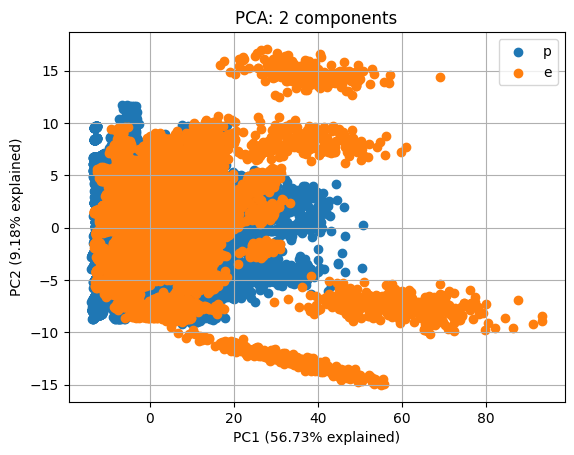

In [29]:
# visualize
colors = sns.color_palette("tab10")

target_names = df['class'].unique()

for c, col in zip(range(len(target_names)), colors):
    pca_1 = pca_df["PC1"].to_numpy()[pca_df["class"] == c]
    pca_2 = pca_df["PC2"].to_numpy()[pca_df["class"] == c]
    plt.scatter(pca_1, pca_2, color=col)
plt.xlabel(f"PC1 ({explained[0]}% explained)")
plt.ylabel(f"PC2 ({explained[1]}% explained)")
plt.title(f"PCA: {pca.get_params()['n_components']} components")
plt.legend(target_names)
plt.grid()
plt.show()

In [12]:
pca.components_

array([[ 0.38057385,  0.0333259 ,  0.03109227, -0.01331124,  0.0067627 ,
         0.07119432, -0.01392917,  0.03900877,  0.15121041,  0.90534278,
        -0.00418466,  0.00107067,  0.00758291,  0.05905205,  0.002345  ],
       [ 0.22171653, -0.02494118, -0.13328491,  0.61248681, -0.00225059,
         0.02277512,  0.00614367,  0.45338374,  0.07762162, -0.10763865,
         0.57555546,  0.00289505,  0.0217404 , -0.0426102 ,  0.0049484 ]])

In [13]:
pca.explained_variance_

array([119.98858548,  19.41750483])

In [14]:
principalComponents

array([[ 9.47417667,  8.40405354],
       [11.13259151,  8.65358149],
       [ 9.73829544,  8.13622412],
       ...,
       [-8.03026509,  0.6624087 ],
       [-8.96234011,  0.75751585],
       [-8.99347618,  0.69191542]])

In [30]:
X_train, X_test, y_train, y_test = train_test_split(pca_df, y, test_size=0.2, random_state=0)

# define k as hyperparameter, take a wild guess
clusters = 2

# model generation
kMeans = KMeans(n_clusters=clusters, n_init="auto")
kMeans.fit(X_train)
train_labels = kMeans.labels_

X_train

,PC1,PC2,class
21214,-3.181113,0.522564,1
27418,20.446758,0.867586,0
16731,3.375746,-3.057597,1
29141,-5.987910,0.170315,0
29962,-7.805222,-5.457019,1
...,...,...,...
45891,-10.523028,0.571553,1
52416,5.112830,5.366743,1
42613,0.423275,-3.425832,1
43567,6.344924,-0.722630,1


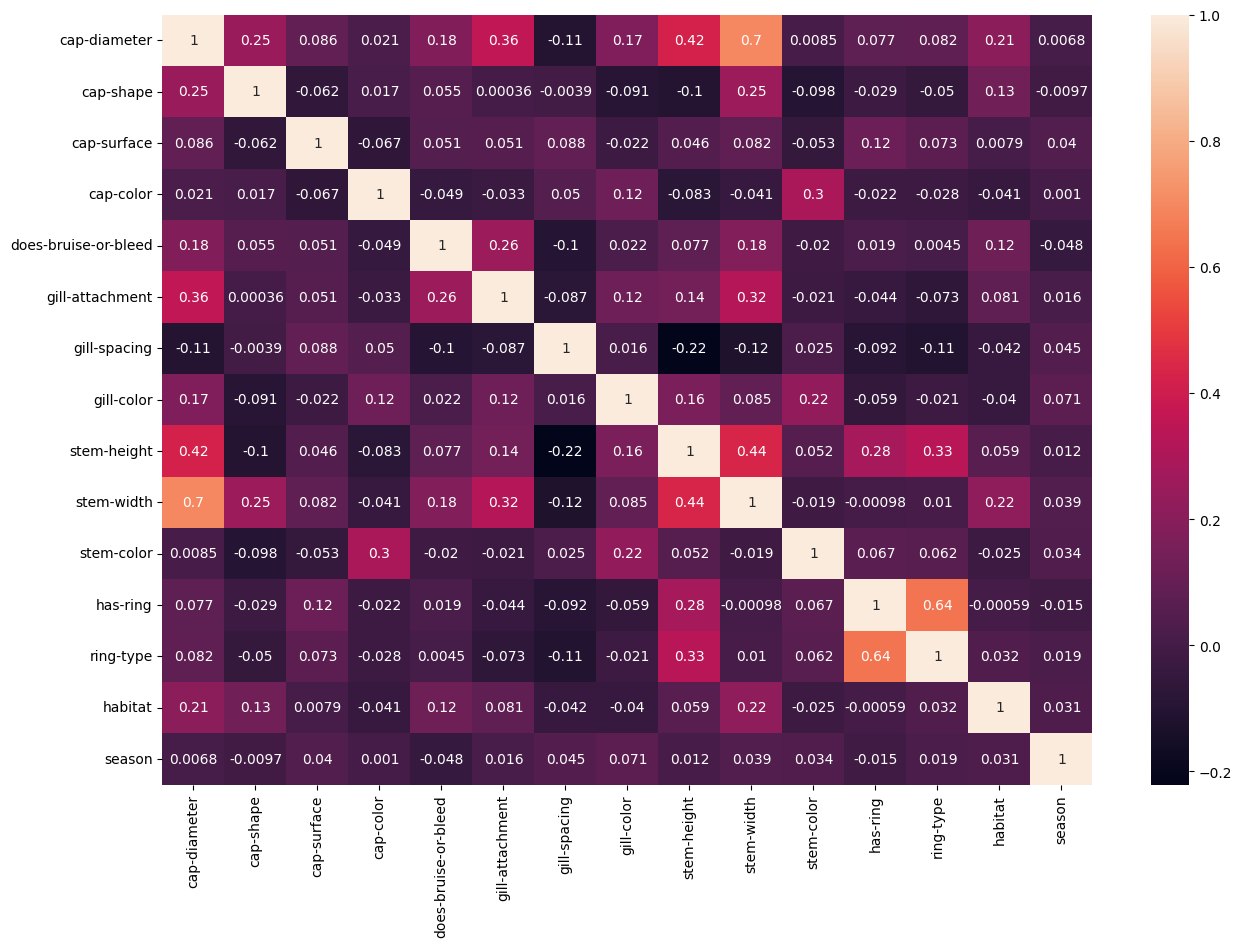

In [15]:
import seaborn as sns

plt.figure(figsize = (15, 10))

# generating correlation heatmap
sns.heatmap(X.corr(), annot = True)
 
# show correlation heatmap
plt.show()

### Finding the best $ k $

What is the best $ k $ ?

If the data is naturally organized into a number of distinct clusters, then it is easy to visually examine it and draw some inferences. But this is rarely the case in the real world. The data in the real world is huge and messy. So we need a way to quantify the quality of the clustering.

##### Silhouette score

`Silhouette` refers to a method used to check the consistency of clusters in our data. It gives an estimate of how well each data point fits with its cluster.

The `silhouette score` is a __metric__ that measures how similar a data point is to its own cluster, as compared to other clusters. The silhouette score works with any similarity metric.
<br><br>

For each data point, the _silhouette_score_ is computed:

> &nbsp;  
> $ silhouette\_score = \left( p - q \right) / max \left( p, q \right) $
> <br><br>

with:

$ p $ ... mean distance to the points in the nearest cluster that the data point is not a part of  
$ q $ ... mean intra-cluster distance to all the points in its own cluster.

The value of the _silhouette_score_ lies between [-1, 1]. 
<br><br>


A score closer to 1 indicates that the data point is very similar to other data points in the cluster, whereas a score closer to -1 indicates that the data point is not similar to the data points in its cluster. 

One way to think about it is if you get too many points with negative silhouette scores, then we may have too few or too many clusters in our data. We need to run the clustering algorithm again to find the optimal number of clusters.

Let's see how to estimate the clustering performance using silhouette scores.

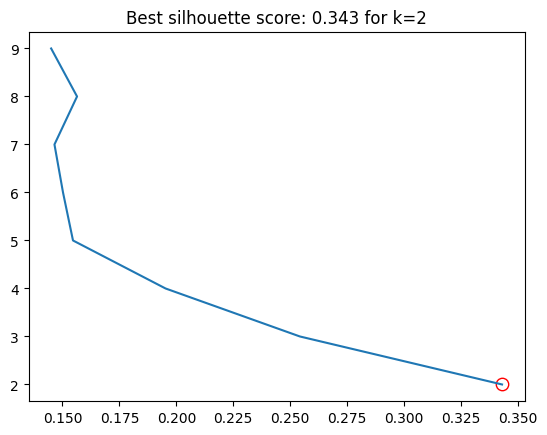

In [16]:
# we use the data above (X, X_train, X_test)
values = np.arange(2, 10)
scores = []

# Iterate through the defined range
for k in values:
    kM = KMeans(n_clusters=k, n_init="auto")
    kM.fit(X_train)
    score = silhouette_score(X_train, kM.labels_, metric='euclidean', sample_size=len(X_train))
    scores.append([k, score])

# find best k and plot
ss = np.array(scores)
max_ss = max(ss[:, 1])
best = [i for i, ss in enumerate(ss[:, 1]) if ss == max_ss][0]
best_k, best_ss = ss[best, 0], ss[best, 1]
plt.plot(ss[:, 1], ss[:, 0])
plt.scatter(best_ss, best_k, c="white", s=80, edgecolors="red")
plt.title(f"Best silhouette score: {best_ss:.3f} for k={best_k:.0f}")
plt.show()

#### Inner inertia

Assuming the data points of a cluster should be "close" to the cluster centers (and the clusters should be "far" from each other, i.e. well-separated).

This means that the __inner variance__ (= sum of squared distances of data points to cluster center) should be as small as possible. 

The total variance is returned as `inertia`.

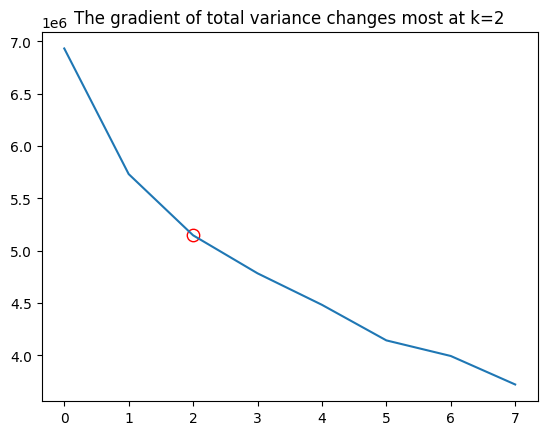

In [17]:
# calculate the total variance and visualize inertia
total_variance = [KMeans(n_clusters=k, n_init="auto").fit(X_train).inertia_ for k in values]

plt.plot(total_variance)
plt.title(f"The gradient of total variance changes most at k={best_k:.0f}")
plt.scatter(2, total_variance[2], c="white", s=80, edgecolors="red")
plt.show()

The optimum number of clusters can be found where the inertia changes its gradient significantly (where the graph "bends").

Computing the optimum number of clusters from the inertia requires some Python programming (that we leave to the student as an exercise).